In [1]:
%load_ext autoreload
%autoreload 2

from gpu import set_gpu
import numpy as np
import os
import adapt.utils.data_utils as prd
import adapt.loop as lp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import adapt.ml.dl_subclass as dl
import copy as cp

set_gpu()

Using TensorFlow backend.


Num GPUs Available:  1


In [2]:
path = 'C:/Users/yteh/Documents/work/necal/home data/TR58/DATA/MAT/'
all_files = os.listdir(path)
train_file = all_files[0]
train_file2 = all_files[1]
ft= 'feat'

In [3]:
all_files = np.delete(all_files,0)

In [3]:
train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
train_data = train_data[:,:8,:]

train_dof = np.unique(train_params[:,2])
key = np.empty(train_dof.shape)
for i in range(len(train_dof)):
    key[i] = train_params[np.argmax(train_params[:,2] == train_dof[i]),0]

In [ ]:
train_data2, train_params2 = prd.load_caps_train(path + train_file2 + '/traindata.mat')
train_data2 = train_data2[:,:8,:]
train_data = np.vstack((train_data,train_data2))
train_params = np.vstack((train_params,train_params2))

In [4]:
# Prep initial training data
ep = 30
n_dof = len(train_dof)

trainmlp_0, traincnn_0, y_train_0, x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b = False, batch_size=128,ft=ft, noise=True)
y_test_0, x_test_mlp_0, x_test_cnn_0, x_lda_0, y_lda_0 = prd.prep_test_caps(train_data, train_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft)


In [5]:
# Initial training
mlp, cnn, w, c = lp.train_models(traincnn_0, trainmlp_0, x_train_lda_0, y_train_lda_0, n_dof, ep=ep)
mlp_0 = mlp.get_weights()
cnn_0 = cnn.get_weights()
w_0 = cp.deepcopy(w)
c_0 = cp.deepcopy(c)

In [6]:
# Test all controllers without recalibration or adaptation
acc = np.empty((len(all_files),4))

for i in range(0,len(all_files)):
    # load data
    test_file = all_files[i]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:].astype('float64')
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft)
    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c])
    print ('Set: ' + test_file, f'CNN Accuracy: {acc[i,2]:.2f},', f'MLP Accuracy: {acc[i,1]:.2f},', f'LDA Accuracy: {acc[i,0]:.2f}')

Set: 20170728_103239 CNN Accuracy: 93.59, MLP Accuracy: 67.54, LDA Accuracy: 82.07
Set: 20170730_054913 CNN Accuracy: 75.58, MLP Accuracy: 66.62, LDA Accuracy: 68.52
Set: 20170730_055812 CNN Accuracy: 74.30, MLP Accuracy: 67.47, LDA Accuracy: 73.77
Set: 20170730_060537 CNN Accuracy: 69.16, MLP Accuracy: 62.66, LDA Accuracy: 70.14
Set: 20170730_123937 CNN Accuracy: 71.37, MLP Accuracy: 54.11, LDA Accuracy: 67.58
Set: 20170731_123147 CNN Accuracy: 68.54, MLP Accuracy: 62.12, LDA Accuracy: 54.48
Set: 20170801_053500 CNN Accuracy: 66.85, MLP Accuracy: 62.65, LDA Accuracy: 55.77
Set: 20170801_054938 CNN Accuracy: 73.21, MLP Accuracy: 69.58, LDA Accuracy: 64.22
Set: 20170801_065547 CNN Accuracy: 70.39, MLP Accuracy: 55.87, LDA Accuracy: 64.10
Set: 20170802_050945 CNN Accuracy: 71.96, MLP Accuracy: 76.96, LDA Accuracy: 63.83
Set: 20170802_051732 CNN Accuracy: 67.25, MLP Accuracy: 59.47, LDA Accuracy: 63.61
Set: 20170802_052140 CNN Accuracy: 73.63, MLP Accuracy: 73.25, LDA Accuracy: 68.87
Set:

Initial train acc: 0.1133, val acc 0: 0.1098
Final train acc: 0.7318,  val acc 0: 0.7702
Initial train acc: 0.6709, val acc 0: 0.7702, val acc 1: 0.7255
Final train acc: 0.8652,  val acc 0: 0.6842, val acc 1: 0.8971
EWC: 20170730_054913, Test: 20170730_055812, EWC Accuracy: 79.72, a-CNN Accuracy: 77.06, a-MLP Accuracy: 82.48, r-CNN Accuracy: nan, r-MLP Accuracy: nan, r-LDA Accuracy: 79.62
Initial train acc: 0.7259, val acc 0: 0.8971, val acc 1: 0.7397
Final train acc: 0.7666,  val acc 0: 0.8321, val acc 1: 0.7963
EWC: 20170730_060537, Test: 20170730_123937, EWC Accuracy: 74.42, a-CNN Accuracy: 77.42, a-MLP Accuracy: 80.91, r-CNN Accuracy: nan, r-MLP Accuracy: nan, r-LDA Accuracy: 79.34
Initial train acc: 0.5790, val acc 0: 0.7963, val acc 1: 0.5827
Final train acc: 0.7117,  val acc 0: 0.7869, val acc 1: 0.7262
EWC: 20170731_123147, Test: 20170801_053500, EWC Accuracy: 60.82, a-CNN Accuracy: 65.03, a-MLP Accuracy: 63.25, r-CNN Accuracy: nan, r-MLP Accuracy: nan, r-LDA Accuracy: 61.06
In

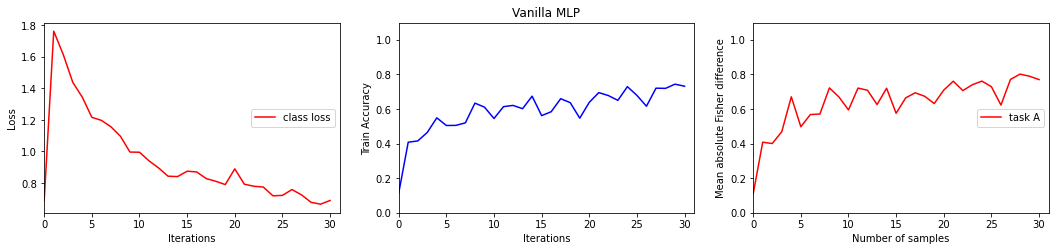

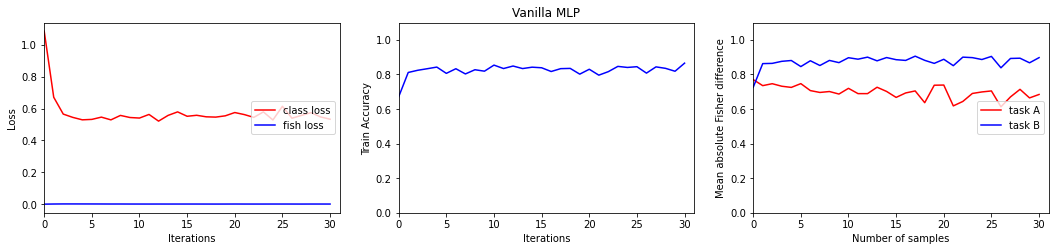

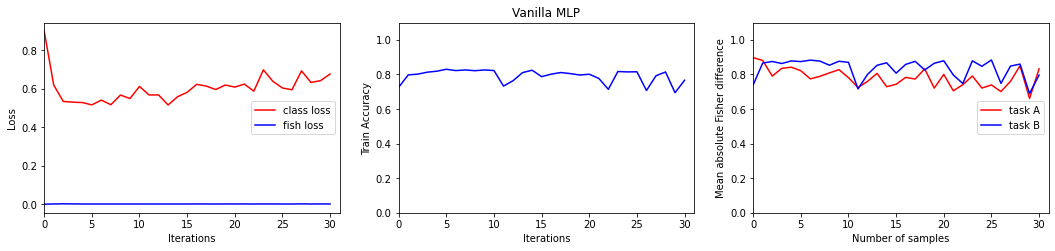

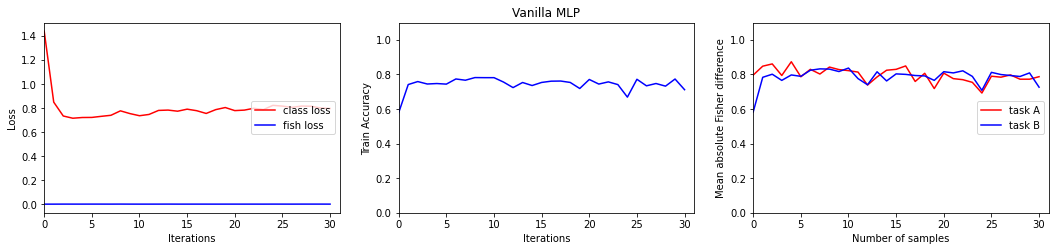

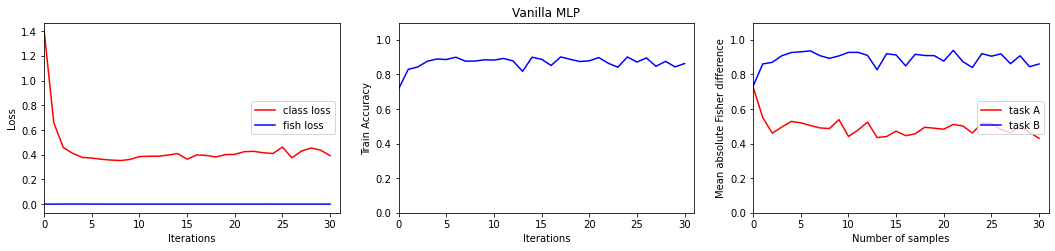

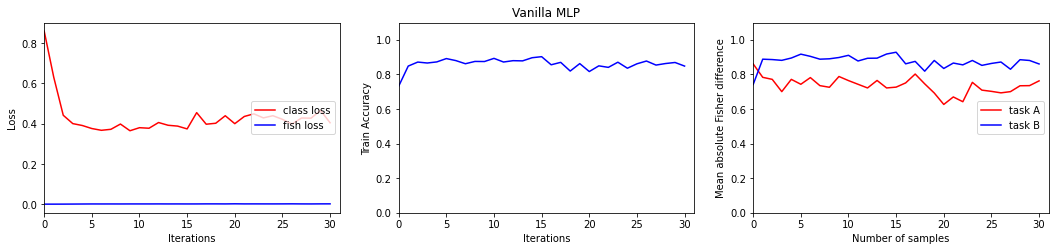

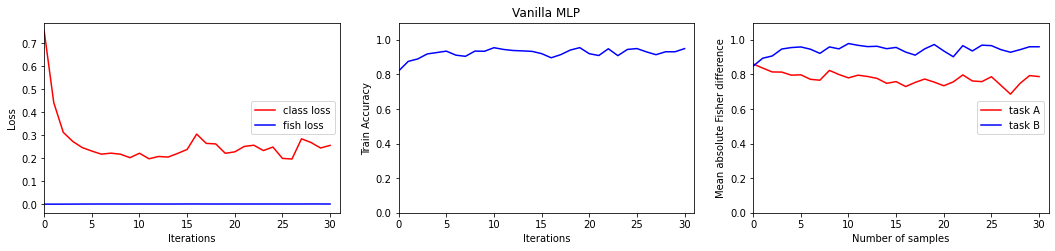

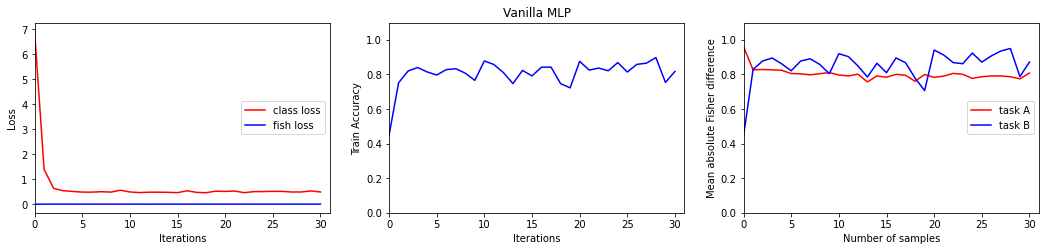

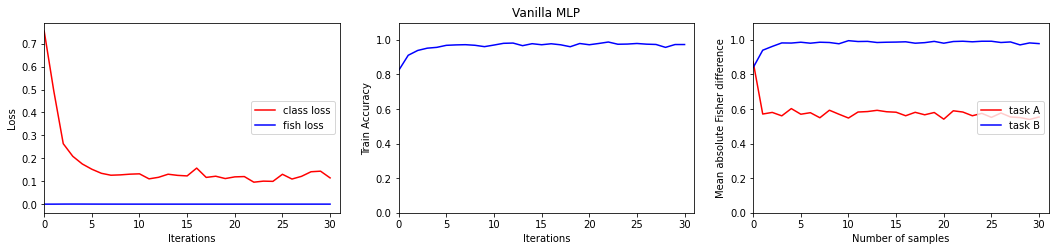

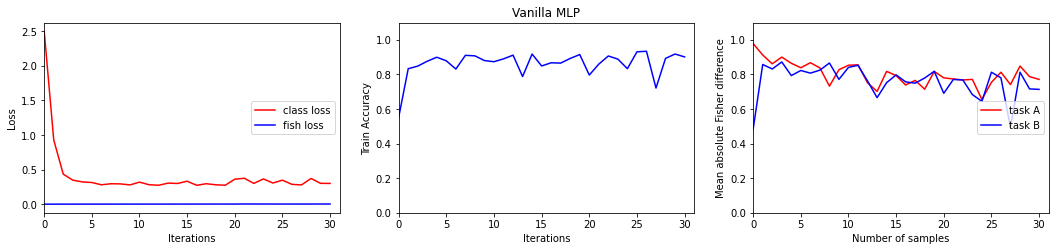

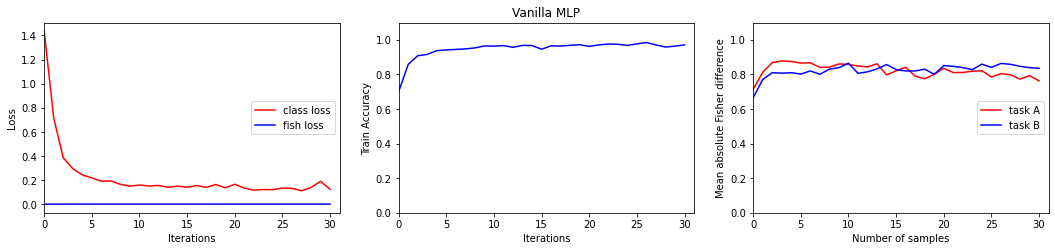

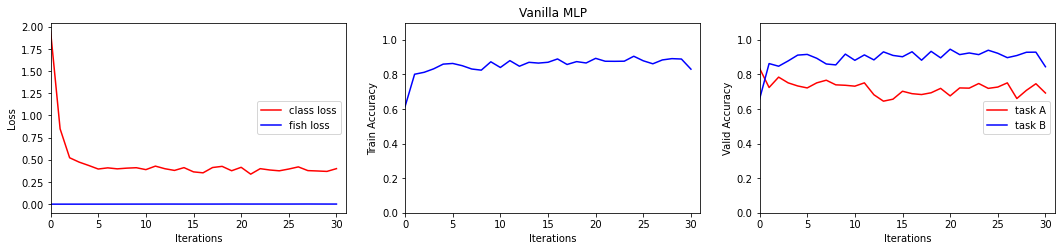

In [7]:
# Test all controllers with ewc
ep = 30
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
ewc_acc = np.empty((len(all_files),4))
ewc_acc[:] = np.nan
rec_acc = np.empty((len(all_files),4))
rec_acc[:] = np.nan

n_dof = len(train_dof)

cnn.set_weights(cnn_0)
mlp.set_weights(mlp_0)

ewc = dl.EWC()
ewc(x_train_mlp_0[:1,...])
loss, fish_loss = lp.train_task(ewc, ep, 1, x_train_mlp_0,y_train_0, [x_test_mlp_0],[y_test_0], lams=[0])
x_train_ewc = cp.deepcopy(x_train_mlp_0)
y_train_ewc = cp.deepcopy(y_train_0)
x_test_ewc_0 = cp.deepcopy(x_test_mlp_0)
y_test_ewc_0 = cp.deepcopy(y_test_0)

ewc_acc[0,:] = lp.test_models(x_test_cnn_0, x_test_mlp_0, x_lda_0, y_test_0, y_lda_0, cnn, mlp, [w_0, c_0], ewc)

for i in range(1,len(all_files)-1,2):
    # load recalibration data
    ewc_file = all_files[i]
    ewc_data, ewc_params = prd.load_caps_train(path + ewc_file + '/traindata.mat')
    ewc_data = ewc_data[:,:8,:]

    ewc.compute_fisher(x_train_ewc, y_train_ewc, num_samples=200, plot_diffs=True) # use validation set for Fisher computation
    ewc.star()

    # check class labels
    ewc_data, ewc_params = lp.check_labels(ewc_data, ewc_params, train_dof, key)
    
    ewcmlp, ewccnn, y_train_ewc, x_train_ewc, _, x_train_lda, y_train_lda, _, _, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=128, noise=True, scaler=scaler, emg_scale=emg_scale,ft=ft)
    y_test_ewc, x_test_ewc, _, _, _ = prd.prep_test_caps(ewc_data, ewc_params, scaler, emg_scale, num_classes=n_dof,ft=ft)

    loss, fish_loss = lp.train_task(ewc, 30, 1, x_train_ewc,y_train_ewc, [x_test_ewc_0, x_test_ewc], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
    mlp, cnn, w, c = lp.train_models(ewccnn, ewcmlp, x_train_lda, y_train_lda, n_dof, 5, mlp, cnn)
    mlp_r, cnn_r, _, _ = lp.train_models(ewccnn, ewcmlp, n_dof=n_dof, ep=30)

    # load test data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:].astype('float64')
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data, test_params, train_dof, key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof,ft=ft)
    ewc_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w,c],ewc)
    # rec_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn_r, mlp_r)

    x_test_ewc_0 = cp.deepcopy(x_test_ewc)
    y_test_ewc_0 = cp.deepcopy(y_test_ewc)

    print ('EWC: ' + ewc_file + ', Test: ' + test_file + ',', f'EWC Accuracy: {ewc_acc[i+1,3]:.2f},', f'a-CNN Accuracy: {ewc_acc[i+1,2]:.2f},', f'a-MLP Accuracy: {ewc_acc[i+1,1]:.2f},',  f'r-CNN Accuracy: {rec_acc[i+1,2]:.2f},', f'r-MLP Accuracy: {rec_acc[i+1,1]:.2f},', f'r-LDA Accuracy: {ewc_acc[i+1,0]:.2f}')

In [ ]:
# Test all controllers with adaptation
ep = 5
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
adapt_acc = np.empty((len(all_files),3))
adapt_acc[:] = np.nan
n_dof = len(train_dof)

for i in range(1,len(all_files)-1,2):
    # load recalibration data
    adapt_file = all_files[i]
    adapt_data, adapt_params = prd.load_caps_train(path + adapt_file + '/traindata.mat')
    adapt_data = adapt_data[:,:8,:]

    # check class labels
    adapt_data, adapt_params = lp.check_labels(adapt_data, adapt_params, train_dof, key)
    
    adaptmlp, adaptcnn, _, _, _, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(adapt_data, adapt_params, prop_b = False, num_classes=n_dof, batch_size=16, noise=True, scaler=scaler, emg_scale=emg_scale,ft=ft)
    mlp, cnn, w, c = lp.train_models(adaptcnn, adaptmlp, x_train_lda, y_train_lda, n_dof, ep, mlp, cnn)
    
    # load data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:].astype('float64')
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data, test_params, train_dof, key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof,ft=ft)
    adapt_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c])

    print ('Adapt: ' + adapt_file + ', Test: ' + test_file, f', CNN Accuracy: {adapt_acc[i+1,2]:.2f},', f'MLP Accuracy: {adapt_acc[i+1,1]:.2f},', f'LDA Accuracy: {adapt_acc[i+1,0]:.2f}')

In [ ]:
# Test all controllers with recalibration
ep = 30
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
recal_acc = np.empty((len(all_files),3))
recal_acc[:] = np.nan

for i in range(1,len(all_files)-1,2):
    # load recalibration data
    recal_file = all_files[i]
    recal_data, recal_params = prd.load_caps_train(path + recal_file + '/traindata.mat')
    recal_data = recal_data[:,:8,:]

    recal_dof = np.unique(recal_params[:,2])
    recal_key = np.empty(recal_dof.shape)
    for dof_i in range(len(recal_dof)):
        recal_key[dof_i] = recal_params[np.argmax(recal_params[:,2] == recal_dof[dof_i]),0]
    n_recal_dof = len(recal_dof)
    
    recalmlp, recalcnn, _, _, _, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(recal_data, recal_params, prop_b = False,ft=ft,batch_size=32)
    mlp, cnn, w, c = lp.train_models(recalcnn, recalmlp, x_train_lda, y_train_lda, n_recal_dof, ep)
    
    # load data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:].astype('float64')
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,recal_dof,recal_key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_recal_dof,ft=ft)
    recal_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c])

    print ('Recal: ' + recal_file + ', Test: ' + test_file, f', CNN Accuracy: {recal_acc[i+1,2]:.2f},', f'MLP Accuracy: {recal_acc[i+1,1]:.2f},', f'LDA Accuracy: {recal_acc[i+1,0]:.2f}')

In [ ]:
# Test all controllers with adaptation
ep = 15
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
align_acc = np.empty((len(all_files),3))
align_acc[:] = np.nan
n_dof = len(train_dof)

for i in range(1,len(all_files)-1,2):
    # load recalibration data
    align_file = all_files[i]
    align_data, align_params = prd.load_caps_train(path + align_file + '/traindata.mat')
    align_data = align_data[:,:8,:]

    # check class labels
    align_data, align_params = lp.check_labels(align_data, align_params, train_dof, key)
    
    alignmlp, aligncnn, _, _, _, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(align_data, align_params, prop_b = False, num_classes=n_dof, batch_size=64, noise=True, scaler=scaler, emg_scale=emg_scale,ft=ft)
    mlp, cnn, mlp_ali, cnn_ali, w, c = lp.train_models(aligncnn, alignmlp, x_train_lda, y_train_lda, n_dof, ep, mlp, cnn, align=True)
    
    # load data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:].astype('float64')
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data, test_params, train_dof, key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof,ft=ft)
    align_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c], cnn_align=cnn_ali, mlp_align=mlp_ali)

    print ('Align: ' + align_file + ', Test: ' + test_file, f', CNN Accuracy: {align_acc[i+1,2]:.2f},', f'MLP Accuracy: {align_acc[i+1,1]:.2f},', f'LDA Accuracy: {align_acc[i+1,0]:.2f}')

In [ ]:
if acc.shape[0] > recal_acc.shape[0]:
    acc = np.delete(acc,-1,axis=0)

In [ ]:
colors =  cm.get_cmap('tab20c')
c = np.empty((20,4))
for i in range(20):
    c[i,:] = colors(i*1/20)
col = np.empty((7,4))
col[0,:] = np.array([0,0,0,1])
col[1,:] = c[8,:]
col[2,:] = c[0,:]
col[3,:] = c[9,:]
col[4,:] = c[1,:]
col[5,:] = c[10,:]
col[6,:] = c[2,:]

In [ ]:
for mod in range(1,3):
    nnVlda = acc[:,mod] - acc[:,0]
    annVlda = adapt_acc[:,mod] - acc[:,0]
    rnnVlda = recal_acc[:,mod] - acc[:,0]
    nnVrlda = acc[:,mod] - recal_acc[:,0]
    annVrlda = adapt_acc[:,mod] - adapt_acc[:,0]
    rnnVrlda = recal_acc[:,mod] - recal_acc[:,0]
    mask = ~np.isnan(annVrlda)
    
    fig,ax = plt.subplots(1,3,figsize=(16,4))

    ax[0].plot(acc[mask,0],'o-',color=col[0,:])
    ax[0].plot(recal_acc[mask,0], 'o--',color=col[0,:])
    ax[0].plot(acc[mask,mod],'o-',color=col[mod,:])
    ax[0].plot(recal_acc[mask,mod], 's-',color=col[mod+2,:])
    ax[0].plot(adapt_acc[mask,mod], 'v-',color=col[mod+4,:])
    if mod == 1:
        ax[0].legend(['LDA', 'r-LDA', 'MLP', 'r-MLP', 'a-MLP', ])
    else:
        ax[0].legend(['LDA', 'r-LDA', 'CNN', 'r-CNN', 'a-CNN'])
    ax[0].set_ylim([0,100])

    ax[1].plot(nnVrlda[mask],'o-',color=col[mod,:])
    ax[1].plot(rnnVrlda[mask],'s-',color=col[mod+2,:])
    ax[1].plot(annVrlda[mask],'v-',color=col[mod+4,:])
    if mod == 1:
        ax[1].legend(['MLP vs. r-LDA', 'r-MLP vs. r-LDA', 'a-MLP vs. r-LDA'])
    else:
        ax[1].legend(['CNN vs. r-LDA', 'r-CNN vs. r-LDA', 'a-CNN vs. r-LDA'])
    ax[1].axhline(0, ls = '--',color='black')

    ax[2].plot(nnVlda[mask],'o-',color=col[mod,:])
    ax[2].plot(rnnVlda[mask],'s-',color=col[mod+2,:])
    ax[2].plot(annVlda[mask],'v-',color=col[mod+4,:])
    if mod == 1:
        ax[2].legend(['MLP vs. LDA', 'r-MLP vs. LDA', 'a-MLP vs. LDA'])
    else:
        ax[2].legend(['CNN vs. LDA', 'r-CNN vs. LDA', 'a-CNN vs. LDA'])
    ax[2].axhline(0, color='black')

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
x = range(0,acc.shape[0]-2,1)
x_skip = range(0,acc.shape[0]-2,2)

for i in range(3):
    ax[0].plot(x_skip,acc[2::2,i],'o',color=col[i,:], label='_nolegend_')
    ax[0].plot(x,acc[2:,i],'-',color=col[i,:])

    if i == 0:
        ls = 's--'
    else:
        ls = 's-'
    ax[1].plot(x_skip,recal_acc[mask,i], ls,color=col[i,:])

    if i > 0:
        ax[2].plot(x_skip,adapt_acc[mask,i], 'v-',color=col[i,:])

    ax[i].set_ylim([0,100])

ax[0].legend(['LDA','MLP','CNN'])
ax[1].legend(['r-LDA','r-MLP','r-CNN'])
ax[2].legend(['a-MLP','a-CNN'])  